### Import Libraries

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load Data

In [23]:
file_path = 'train.xlsx'
data = pd.read_excel(file_path)

In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32036 entries, 0 to 32035
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   review_description  32036 non-null  object
 1   rating              32036 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.7+ KB


In [25]:
data.head()

,review_description,rating
0,شركه زباله و سواقين بتبرشم و مفيش حتي رقم للشك...,-1
1,خدمة الدفع عن طريق الكي نت توقفت عندي اصبح فقط...,1
2,تطبيق غبي و جاري حذفه ، عاملين اكواد خصم و لما...,-1
3,فعلا تطبيق ممتاز بس لو فى امكانية يتيح لمستخدم...,1
4,سيء جدا ، اسعار رسوم التوصيل لا تمت للواقع ب ص...,-1


### Basic preprocessing

##### Checking for null values

In [26]:
data.isnull().sum()

review_description    0
rating                0
dtype: int64

##### Lowercase 

In [27]:
data['preprocessed_review'] = data['review_description'].str.lower()

##### Dealing with duplicated reviews


In [28]:
data.duplicated().sum()

652

In [29]:
data = data.drop_duplicates(subset='preprocessed_review')
data.duplicated().sum()

0

### EDA

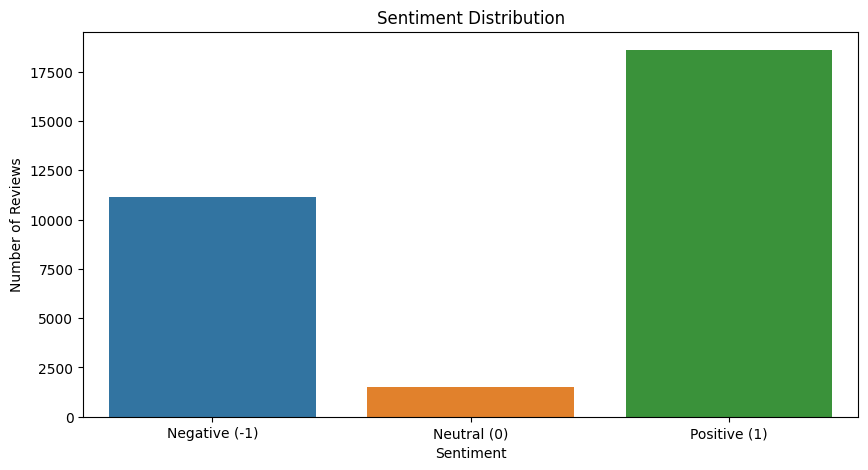

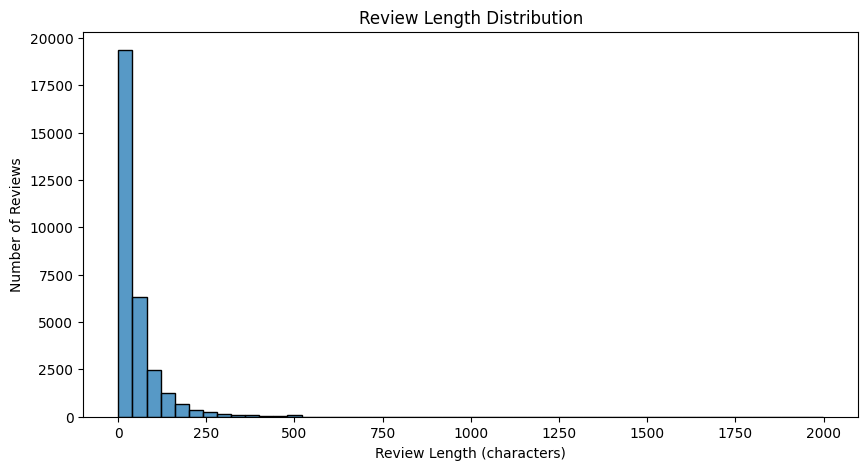

In [30]:
# Sentiment Distribution
sentiment_counts = data['rating'].value_counts()

# Review Length Analysis
data['review_length'] = data['review_description'].apply(len)

# Plotting the sentiment distribution
plt.figure(figsize=(10, 5))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(ticks=[0, 1, 2], labels=['Negative (-1)', 'Neutral (0)', 'Positive (1)'])
plt.show()

# Plotting the distribution of review lengths
plt.figure(figsize=(10, 5))
sns.histplot(data['review_length'], bins=50)
plt.title('Review Length Distribution')
plt.xlabel('Review Length (characters)')
plt.ylabel('Number of Reviews')
plt.show()

In [31]:
sentiment_counts

rating
 1    18599
-1    11157
 0     1490
Name: count, dtype: int64

In [32]:
data['review_length'].describe()

count    31246.000000
mean        51.795334
std         68.208548
min          1.000000
25%         15.000000
50%         29.000000
75%         61.000000
max       1998.000000
Name: review_length, dtype: float64